## Problem

Detecting whether an article is Fake News using Stance Detection. Stance detection takes a headline and body text of an article and classifies the stance of the body text relative to headline. 

In [1]:
import pandas as pd 

import os
import re
import nltk
from sklearn import feature_extraction
from tqdm import tqdm


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns
from nltk.stem import WordNetLemmatizer

In [2]:
bodies = pd.read_csv('./train_bodies.csv')
stances = pd.read_csv('./train_stances.csv')


# EDA

In [3]:
bodies.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [4]:
stances.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [5]:
stances[stances['Body ID'] == 712]

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1787,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss
3974,Mexico police find mass grave near site 43 stu...,712,unrelated
4936,Mexico Says Missing Students Not Found In Firs...,712,unrelated
5210,New iOS 8 bug can delete all of your iCloud do...,712,unrelated
5863,Return of the Mac: Seth Rogen in talks to star...,712,discuss
6199,Seth Rogen Is Woz,712,discuss
6756,Mexico finds 4 more graves at site of suspecte...,712,unrelated
7526,Are missing students in mass graves found near...,712,unrelated
9003,Mexico prosecutor: Students not in 1st mass gr...,712,unrelated


In [6]:
stances['Body ID'].value_counts()

1921    187
1948    175
40      172
524     171
1549    166
304     154
1385    151
125     145
2367    143
220     141
1438    141
195     140
2296    136
35      131
1786    131
1883    131
2520    127
1034    127
2252    126
1574    125
2307    125
527     125
2175    124
1627    123
2404    123
1289    122
2115    121
2096    120
1040    118
1893    117
       ... 
907       1
370       1
210       1
146       1
114       1
1542      1
63        1
76        1
390       1
515       1
193       1
464       1
355       1
323       1
624       1
282       1
18        1
797       1
701       1
362       1
2311      1
6         1
915       1
70        1
151       1
376       1
140       1
307       1
1066      1
59        1
Name: Body ID, Length: 1683, dtype: int64

In [7]:
stances['Stance'].unique()

array(['unrelated', 'agree', 'disagree', 'discuss'], dtype=object)

In [8]:
print('Bodies shape:', bodies.shape)
print('Stances shape:', stances.shape)


Bodies shape: (1683, 2)
Stances shape: (49972, 3)


In [9]:
stances['Stance'].value_counts()/stances.shape[0]

unrelated    0.731310
discuss      0.178280
agree        0.073601
disagree     0.016809
Name: Stance, dtype: float64

In [10]:
#why are stances rows much larger

In [11]:
bodies.isnull().sum()

Body ID        0
articleBody    0
dtype: int64

In [12]:
stances.isnull().sum()

Headline    0
Body ID     0
Stance      0
dtype: int64

In [13]:
bodies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 2 columns):
Body ID        1683 non-null int64
articleBody    1683 non-null object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


In [14]:
stances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
Headline    49972 non-null object
Body ID     49972 non-null int64
Stance      49972 non-null object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [177]:
print("Total stances: " + str(len(stances.Stance)))
print("Total article bodies: " + str(len(bodies.articleBody)))

Total stances: 49972
Total article bodies: 1683


In [249]:
#merge on bodyID 

df_all = stances.merge(bodies, on = 'Body ID')
#df_all = df_all.drop('Stance', axis =1)
df_all.head()

,Headline,Body ID,Stance,articleBody,txt_process
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...,"[danny, boyle, directing, untitled, film, seth..."
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\n\n...,"[danny, boyle, directing, untitled, film, seth..."
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\n\n...,"[danny, boyle, directing, untitled, film, seth..."
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\n\n...,"[danny, boyle, directing, untitled, film, seth..."
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\n\n...,"[danny, boyle, directing, untitled, film, seth..."


In [250]:
df_all.isnull().sum()

Headline       0
Body ID        0
Stance         0
articleBody    0
txt_process    0
dtype: int64

In [251]:
df_all.shape

(49972, 5)

## Baseline

In [252]:
stances['Stance'].value_counts(normalize=True)

unrelated    0.731310
discuss      0.178280
agree        0.073601
disagree     0.016809
Name: Stance, dtype: float64

# NLP

## Count Vectorizer

In [414]:
#body
X_train = df_all[['articleBody']]
y_train = stances['Stance']
X_test = df_all[['articleBody']]
y_test = stances['Stance']

cvec_body = CountVectorizer(stop_words = 'english')

train_body_cvec = cvec_body.fit_transform(X_train['articleBody'])
test_body_cvec = cvec_body.transform(X_test['articleBody'])

lr = LogisticRegression()
lr.fit(train_body_cvec, y_train)
lr.score(test_body_cvec, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [49970, 49972]

In [413]:
#headline
X_train = df_all[['Headline']]
y_train = stances['Stance']
X_test = df_all[['Headline']]
y_test = stances['Stance']

cvec_headline= CountVectorizer(stop_words = 'english')

train_headline_cvec = cvec_headline.fit_transform(X_train['Headline'])
test_headline_cvec = cvec_headline.transform(X_test['Headline'])

lr = LogisticRegression()
lr.fit(train_headline_cvec, y_train)
lr.score(test_headline_cvec, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [49970, 49972]

In [24]:
#combine headline and body cvec and that will be x_train
#fit model on X_train 
#if model doesnt do well do truncated svd then cosine similarity between bodies and headline which will become a feature 


In [25]:
#do i still need these 
#df  = pd.DataFrame(X_test_count.todense(),
                   #columns=cvec.get_feature_names(), index = [bodies.articleBody]) 
#df.head()


In [26]:
#df.sort_index(axis = 0, ascending=False).head()

In [27]:
#df.sum().sort_values(ascending=False).head(10)

In [28]:
#df = df.reindex_axis(df.sum().sort_values(ascending=False).index, axis =1)
#df

# Hashing Vectorizer

In [29]:
#body
X_train = df_all[['articleBody']]
y_train = stances['Stance']
X_test = df_all[['articleBody']]
y_test = stances['Stance']

In [30]:
hvec_body = HashingVectorizer(stop_words = 'english')

train_body_hvec = hvec_body.fit_transform(X_train['articleBody'])
test_body_hvec = hvec_body.transform(X_test['articleBody'])

lr = LogisticRegression()
lr.fit(train_body_hvec, y_train)
lr.score(test_body_hvec, y_test)

0.7313095333386697

In [31]:
#headline
X_train = df_all[['Headline']]
y_train = stances['Stance']
X_test = df_all[['Headline']]
y_test = stances['Stance']

In [32]:
hvec_headline = HashingVectorizer(stop_words = 'english')

train_headline_hvec = hvec_headline.fit_transform(X_train['Headline'])
test_headline_hvec = hvec_headline.transform(X_test['Headline'])

lr = LogisticRegression()
lr.fit(train_headline_hvec, y_train)
lr.score(test_headline_hvec, y_test)

0.7313095333386697

In [33]:
#df_hv = pd.DataFrame(hvec.transform(X_test).todense(), index=[bodies.articleBody])  
#df_hv.head()

In [34]:
#df_hv.sum().sort_values(ascending=False).head(10)

In [35]:
#df_hv = df_hv.reindex_axis(df_hv.sum().sort_values(ascending=False).index, axis =1)
#df_hv

In [36]:
#what can i do with this 

# TF IDF 

In [37]:
#body
X_train = df_all[['articleBody']]
y_train = stances['Stance']
X_test = df_all[['articleBody']]
y_test = stances['Stance']

In [38]:
tvec_body = TfidfVectorizer(stop_words = 'english')

train_body_tvec = tvec_body.fit_transform(X_train['articleBody'])
test_body_tvec = tvec_body.transform(X_test['articleBody'])

lr = LogisticRegression()
lr.fit(train_body_tvec, y_train)
lr.score(test_body_tvec, y_test)

0.7313095333386697

In [39]:
#headline
X_train = df_all[['Headline']]
y_train = stances['Stance']
X_test = df_all[['Headline']]
y_test = stances['Stance']

In [40]:
tvec_headline = TfidfVectorizer(stop_words = 'english')

train_headline_tvec = tvec_headline.fit_transform(X_train['Headline'])
test_headline_tvec = tvec_headline.transform(X_test['Headline'])

lr = LogisticRegression()
lr.fit(train_headline_tvec, y_train)
lr.score(test_headline_tvec, y_test)

0.7313095333386697

In [41]:
#df_tfidf  = pd.DataFrame(tvec.transform(X_test).todense(),
                   #columns=tvec.get_feature_names(),
                   #index=[bodies.articleBody])
#df_tfidf.head()
#df.transpose().sort_values('bodies.articleBody', ascending=False).head(10).transpose()

In [42]:
#df_tfidf.sort_index(axis = 0, ascending=False).head()

In [43]:
#df_tfidf.sum().sort_values(ascending=False).head(10)

In [44]:
#df_tfidf = df_tfidf.reindex_axis(df_tfidf.sum().sort_values(ascending=False).index, axis =1)
#df_tfidf

## LDA

In [45]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
        1. Tokenizes and removes punctuation
        2. Removes stopwords
        3. Stems
        4. Returns a list of the cleaned text
    '''
    if pd.isnull(text):
        return []
    # tokenizing and removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
    
    # stemming
    #porter_stemmer = PorterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()
    
    text_processed = [wordnet_lemmatizer.lemmatize(word) for word in text_processed]
    
    try:
        text_processed.remove('b')
    except: 
        pass

    return text_processed ## <-- we're keeping our words distinct

In [46]:
bodies['txt_process'] = bodies['articleBody'].apply(text_process)

In [47]:
bodies['txt_process'].head()

0    [small, meteorite, crashed, wooded, area, nica...
1    [last, week, hinted, come, ebola, fear, spread...
2    [newser, wonder, long, quarter, pounder, chees...
3    [posting, photo, gun, toting, child, online, i...
4    [least, 25, suspected, boko, haram, insurgent,...
Name: txt_process, dtype: object

In [48]:
df_all['Headline'] = df_all['Headline'].apply(text_process)

In [49]:
df_all['Headline'].head()

0    [police, find, mass, graf, least, 15, body, ne...
1           [seth, rogen, play, apple, steve, wozniak]
2    [mexico, police, find, mass, grave, near, site...
3    [mexico, say, missing, student, found, first, ...
4          [new, io, 8, bug, delete, icloud, document]
Name: Headline, dtype: object

## Fit LDA Model

In [50]:
from gensim import corpora, models
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

np.random.seed(42)

In [51]:
dictionary = corpora.Dictionary(bodies['txt_process'])

corpus = [dictionary.doc2bow(text) for text in bodies['txt_process']]

ldamodel = models.ldamodel.LdaModel(corpus,                     # pass in our corpus
                                    id2word = dictionary,       # matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 20,             # number of topics T to find
                                    passes = 5,                 # number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # only include topics above this probability threshold

In [52]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
17     12.804306        1       1  0.111491 -0.085515
13      9.752285        1       2  0.079374 -0.043186
12      7.096027        1       3 -0.223387 -0.095773
10      6.532525        1       4 -0.019262  0.029162
11      6.423989        1       5  0.080422 -0.035518
8       6.197753        1       6  0.033236  0.111488
19      5.986520        1       7  0.038135 -0.031822
3       5.566109        1       8  0.065530 -0.070919
16      5.490118        1       9 -0.012115  0.051340
2       5.464538        1      10  0.005687  0.061139
9       5.012520        1      11  0.001150  0.079985
0       3.854950        1      12  0.024443  0.016851
1       3.323574        1      13 -0.084989 -0.068505
6       3.010804        1      14  0.017842 -0.004923
14      2.558052        1      15 -0.026306  0.059355
15      2.441607        1      16 -0.091768 -0.044419
4       2.402087        1      17 -0.020619  0.058582
7       2.311477        1      18  0.053815 -0.051946
5       2.274334        1      19 -0.102630  0.068692
18      1.496426        1      20  0.069951 -0.004067, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
1671  Default  1791.000000       apple  1791.000000  30.0000  30.0000
1718  Default  1222.000000       watch  1222.000000  29.0000  29.0000
2629  Default   605.000000         kim   605.000000  28.0000  28.0000
365   Default  1038.000000         isi  1038.000000  27.0000  27.0000
6     Default   507.000000         air   507.000000  26.0000  26.0000
2189  Default   446.000000       foley   446.000000  25.0000  25.0000
8142  Default   234.000000     macbook   234.000000  24.0000  24.0000
807   Default   583.000000       north   583.000000  23.0000  23.0000
3602  Default   232.000000     comcast   232.000000  22.0000  22.0000
963   Default  1298.000000       video  1298.000000  21.0000  21.0000
144   Default   338.000000       ebola   338.000000  20.0000  20.0000
2628  Default   323.000000        jong   323.000000  19.0000  19.0000
1976  Default   154.000000   rosenberg   154.000000  18.0000  18.0000
461   Default   449.000000      border   449.000000  17.0000  17.0000
2666  Default   298.000000        gold   298.000000  16.0000  16.0000
2631  Default   272.000000      korean   272.000000  15.0000  15.0000
2285  Default   292.000000       brown   292.000000  14.0000  14.0000
1752  Default   405.000000        girl   405.000000  13.0000  13.0000
2630  Default   273.000000       korea   273.000000  12.0000  12.0000
419   Default   666.000000       syria   666.000000  11.0000  11.0000
2565  Default   277.000000         job   277.000000  10.0000  10.0000
165   Default  1067.000000         new  1067.000000   9.0000   9.0000
297   Default   846.000000          al   846.000000   8.0000   8.0000
1382  Default   232.000000     kurdish   232.000000   7.0000   7.0000
364   Default   579.000000        iraq   579.000000   6.0000   6.0000
110   Default  1325.000000       state  1325.000000   5.0000   5.0000
366   Default   812.000000     islamic   812.000000   4.0000   4.0000
490   Default   291.000000       haram   291.000000   3.0000   3.0000
1313  Default   260.000000  parliament   260.000000   2.0000   2.0000
460   Default   287.000000        boko   287.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
6739  Topic20    16.651697    sergeant    63.168152   2.8688  -5.7902
1569  Topic20     8.275397        tied    21.551598   3.2449  -6.4894
1381  Topic20    17.592659        kurd    71.529556   2.7995  -5.7352
454   Topic20    28.223755         arm   155.382782   2.4964  -5.2625
314   Topic20    18.602619      canada    79.919777   2.7444  -5.6794
1340  Topic20    34.232052    captured   248.702148   2.2190  -5.0695
315   Topic20    27.832994    canadian 

In [53]:
dictionary = corpora.Dictionary(list(df_all['Headline']))

corpus = [dictionary.doc2bow(text) for text in df_all['Headline']]

ldamodel = models.ldamodel.LdaModel(corpus,                     # pass in our corpus
                                    id2word = dictionary,       # matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 20,             # number of topics T to find
                                    passes = 5,                 # number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # only include topics above this probability threshold

In [54]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
5      8.492370        1       1  0.081719 -0.226920
3      7.642462        1       2 -0.257230  0.086397
7      7.177767        1       3 -0.197424 -0.049666
13     5.634567        1       4  0.085241 -0.120624
14     5.340482        1       5  0.125922  0.078203
9      5.281558        1       6  0.015138  0.097008
17     5.239816        1       7  0.128605 -0.011263
12     5.217289        1       8 -0.147724 -0.042734
16     5.037133        1       9 -0.212015 -0.029404
1      5.035282        1      10  0.083282  0.065697
8      4.727080        1      11 -0.112678 -0.083775
18     4.586326        1      12 -0.019646  0.051880
19     4.516434        1      13  0.143057  0.215767
0      4.096324        1      14  0.142557  0.165844
15     4.058270        1      15 -0.143812  0.143320
11     4.030931        1      16  0.084750  0.055761
2      4.022765        1      17  0.120109 -0.178751
4      3.684993        1      18  0.065300  0.013138
10     3.231408        1      19 -0.132475 -0.074313
6      2.946738        1      20  0.147324 -0.155566, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
69    Default  7149.000000            isi  7149.000000  30.0000  30.0000
432   Default  2538.000000     journalist  2538.000000  29.0000  29.0000
436   Default  2266.000000            kim  2266.000000  28.0000  28.0000
430   Default  2923.000000          foley  2923.000000  27.0000  27.0000
435   Default  2075.000000           jong  2075.000000  26.0000  26.0000
431   Default  2679.000000          james  2679.000000  25.0000  25.0000
14    Default  2765.000000          apple  2765.000000  24.0000  24.0000
18    Default  1758.000000          steve  1758.000000  23.0000  23.0000
80    Default  2188.000000          watch  2188.000000  22.0000  22.0000
73    Default  3819.000000              u  3819.000000  21.0000  21.0000
37    Default  1649.000000            job  1649.000000  20.0000  20.0000
468   Default  2095.000000          haram  2095.000000  19.0000  19.0000
465   Default  2095.000000           boko  2095.000000  18.0000  18.0000
437   Default  1759.000000             un  1759.000000  17.0000  17.0000
217   Default  2755.000000        islamic  2755.000000  16.0000  16.0000
505   Default  2067.000000          brown  2067.000000  15.0000  15.0000
504   Default  1975.000000          audio  1975.000000  14.0000  14.0000
428   Default  2060.000000       american  2060.000000  13.0000  13.0000
56    Default  2561.000000        michael  2561.000000  12.0000  12.0000
98    Default  1173.000000      christian  1173.000000  11.0000  11.0000
97    Default  1173.000000           bale  1173.000000  10.0000  10.0000
264   Default  2040.000000          ebola  2040.000000   9.0000   9.0000
221   Default  2618.000000          state  2618.000000   8.0000   8.0000
15    Default  1247.000000           play  1247.000000   7.0000   7.0000
71    Default  1596.000000         killed  1596.000000   6.0000   6.0000
348   Default  1068.000000      meteorite  1068.000000   5.0000   5.0000
292   Default  3762.000000         report  3762.000000   4.0000   4.0000
94    Default  2093.000000         leader  2093.000000   3.0000   3.0000
467   Default  1543.000000           girl  1543.000000   2.0000   2.0000
452   Default  2927.000000          video  2927.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
1727  Topic20    77.613846           room    78.554367   3.5124  -5.0915
2009  Topic20    75.558052        confirm    76.498573   3.5121  -5.1183
210   Topic20    70.445366         refuse    71.385887   3.5112  -5.1884
1945  Topic20    62.911098         eleven    63.851620   3.5096  -5.3015
1946  Topic20    62.911098          final    63.851620   3.5096  -5.3015
1951  Topic20    

### preprocessing for Latent Semantic Analysis

In [55]:
import re

In [56]:
def cleaner(text):
    text = re.sub('&#39;','',text).lower()
    text = re.sub('<br />','',text)
    text = re.sub('<.*>.*</.*>','', text)
    text = re.sub('\\ufeff', '', text)
    text = re.sub('[\d]','',text)
    text = re.sub('[^a-z ]','',text)
    
    return text

<input>:6: DeprecationWarning: invalid escape sequence \d
<input>:6: DeprecationWarning: invalid escape sequence \d
<input>:6: DeprecationWarning: invalid escape sequence \d
<ipython-input-56-6de38bea8180>:6: DeprecationWarning: invalid escape sequence \d
  text = re.sub('[\d]','',text)


In [57]:
df_all['articleBody'] = df_all['articleBody'].map(str)
df_all['articleBody'] = df_all['articleBody'].apply(cleaner)

In [58]:
df_all['articleBody'].iloc[1]

'danny boyle is directing the untitled filmseth rogen is being eyed to play apple cofounder steve wozniak in sonys steve jobs biopicdanny boyle is directing the untitled film based on walter isaacsons book and adapted by aaron sorkin which is one of the most anticipated biopics in recent yearsnegotiations have not yet begun and its not even clear if rogen has an official offer but the producers  scott rudin guymon casady and mark gordon  have set their sights on the talent and are in talksof course this may all be for naught as christian bale the actor who is to play jobs is still in the midst of closing his deal sources say that dealmaking process is in a sensitive stageinsiders say boyle will is flying to los angeles to meet with actress to play one of the female leads an assistant to jobs insiders say that jessica chastain is one of the actresses on the meeting listwozniak known as woz cofounded apple with jobs and ronald wayne he first met jobs when they worked at atari and later w

In [59]:
df_all['Headline'] = df_all['Headline'].map(str)
df_all['Headline'] = df_all['Headline'].apply(cleaner)

### tfidf vectorizer

In [ ]:
tfidf_vector = TfidfVectorizer(min_df = 5, stop_words='english')

articleBody_matrix_sparse = tfidf_vector.fit_transform(df_all['articleBody'])
articleBody_matrix_sparse

In [62]:
articleBody_df_tfdf = pd.DataFrame(articleBody_matrix_sparse.toarray(),
                                 index = df_all.index,
                                 columns = tfidf_vector.get_feature_names())

In [63]:
articleBody_df_tfdf.head()

,aafia,aamaq,aamir,aan,aapl,aaron,aback,abadam,abadi,abagnale,...,zobl,zone,zoneclick,zones,zonethis,zoning,zoology,zubeyr,zuckerberg,zulu
0,0.0,0.0,0.0,0.0,0.0,0.073827,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.073827,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.073827,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.073827,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.073827,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
headline_matrix_sparse = tfidf_vector.fit_transform(df_all['Headline'])
headline_matrix_sparse

<49972x2736 sparse matrix of type '<class 'numpy.float64'>'
	with 388147 stored elements in Compressed Sparse Row format>

In [65]:
headline_df_tfdf = pd.DataFrame(headline_matrix_sparse.toarray(),
                                 index = df_all.index,
                                 columns = tfidf_vector.get_feature_names())

In [66]:
headline_df_tfdf.head()

,aaron,abandoned,abdel,abdi,abducted,abducting,abdul,abdullah,abort,aborted,...,younger,youngest,youtube,ypg,yum,zack,zehaf,zeppelin,zero,zhejiang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Truncated SVD

In [67]:
from sklearn.decomposition import TruncatedSVD

In [68]:
n_components = 100
SVD = TruncatedSVD(n_components)
component_names = ["component_"+str(i) for i in range(n_components)]

In [69]:
#lsa = TruncatedSVD(n_components=100, n_iter=100)
#lsa.fit(articleBody_df_tfdf)

In [70]:
#lsa.components_[0]

In [71]:
#terms = vectorizer.get_feature_names()
#for i, comp in enumerate(lsa.components_):
    #termsInComp = zip (terms, comp)
    #sortedTerms = sorted(termsInComp, key=lambda X: x[1], reverse = True)[:10]
    #print "Word %d:" % i
    #for term in sortedTerms:
        #print term[0]
        #print " "

In [72]:
articleBody_svd_matrix = SVD.fit_transform(articleBody_df_tfdf)
articleBody_svd_matrix

array([[ 0.0799979 ,  0.18888767, -0.01010505, ...,  0.00212747,
        -0.00870781,  0.00280373],
       [ 0.0799979 ,  0.18888767, -0.01010505, ...,  0.00212747,
        -0.00870781,  0.00280373],
       [ 0.0799979 ,  0.18888767, -0.01010505, ...,  0.00212747,
        -0.00870781,  0.00280373],
       ...,
       [ 0.10207265, -0.00686561, -0.00822395, ..., -0.01550385,
        -0.0019225 ,  0.01680216],
       [ 0.15893976,  0.45728715, -0.05688312, ...,  0.01927547,
        -0.004254  ,  0.00634994],
       [ 0.16686514,  0.6082468 , -0.09006886, ...,  0.029364  ,
         0.03484511,  0.02267684]])

In [73]:
headline_svd_matrix = SVD.fit_transform(headline_df_tfdf)
headline_svd_matrix

array([[ 0.01147469,  0.00935677,  0.00474748, ..., -0.00369881,
         0.05448288, -0.02057644],
       [ 0.00723104,  0.05075069, -0.00227481, ..., -0.00764918,
         0.00826136,  0.00722945],
       [ 0.01427156,  0.00729176,  0.00614659, ..., -0.01600964,
         0.04163895, -0.01642405],
       ...,
       [ 0.01233551,  0.00230563,  0.00525988, ..., -0.04318453,
         0.02646216, -0.0228314 ],
       [ 0.01735224,  0.015007  ,  0.00583676, ...,  0.01337244,
        -0.03477614, -0.03171191],
       [ 0.00979518,  0.01030199,  0.00912633, ..., -0.02772729,
        -0.00410629,  0.01735378]])

In [74]:
articleBody_svd_matrix.shape

(49972, 100)

In [75]:
#search_term = "islam"

#use headline to compare to the boody 
#make a list forbody and article and loop thru each row 

In [76]:
#search_term_vec = tfidf_vector.transform([search_term])

In [77]:
#search_term_svd = SVD.transform(search_term_vec)

In [410]:
#search_term_svd

## Cosine Similarity

In [79]:
cosine_similarities = articleBody_svd_matrix.dot(search_term_svd.T).ravel()
#do for 1 row with another row --> feature 

In [80]:
cosine_similarities.shape

(49972,)

In [81]:
cosine_similarities

array([ 0.00064089,  0.00064089,  0.00064089, ...,  0.00142274,
       -0.00079384, -0.00144319])

In [82]:
cosine_similarities.argsort()[:-6:-1]

array([10387, 10358, 10350, 10351, 10352])

In [83]:
cosine_similarities_headline = headline_svd_matrix.dot(search_term_svd.T).ravel()

In [85]:
from gensim import corpora, models
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [86]:
#from nltk.corpus import stopwords
#def split_into_words(documents):
    #docs = []
    #for doc in documents:
        #text_processed = doc.split(' ')
        #text_processed = list(filter(lambda a: a != '', text_processed))
        #text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
        #docs.append(text_processed)
    #return docs

In [87]:
#texts = split_into_words(df_all['articleBody'])

## Cosine Similarity

In [141]:
import scipy.spatial as sp

In [142]:
#distances = 1 - sp.distance.cdist(articleBody_svd_matrix, headline_svd_matrix, 'cosine')

In [143]:
distances = []
for i, body in enumerate(articleBody_svd_matrix): 
    distances.append(sp.distance.cdist([body], [headline_svd_matrix[i]], 'cosine')[0][0])

In [255]:
df_all['distances'] = pd.Series(distances)

In [258]:
df_all.shape

(49972, 6)

In [203]:
df_fix = pd.DataFrame([df_all['distances'], y_train_label]).T
df_fix.head()

,distances,Unnamed 0
0,0.791488,3.0
1,0.963682,0.0
2,0.785113,3.0
3,0.723416,3.0
4,0.996359,1.0


In [257]:
df_fix[df_fix['distances'].isnull()==True]

,distances,Unnamed 0


In [220]:
df_fix = df_fix.dropna(axis=0)

In [284]:
df_fix.shape

(49970, 2)

In [259]:
df_all[df_all['distances'].isnull()==True]

,Headline,Body ID,Stance,articleBody,txt_process,distances
29526,Federal Judge: Enough With the Stupid Names,748,unrelated,"Yes, we wished it were true too, but no, Fox N...","[yes, wished, true, fox, news, angrily, respon...",NaN
36317,Federal Judge: Enough With the Stupid Names,2114,agree,(DETROIT) In a decision that’s expected to sen...,"[detroit, decision, expected, send, shockwaves...",NaN


In [260]:
#2 null values 
df_all.shape

(49972, 6)

In [261]:
df_all = df_all.dropna(axis=0)

#why does this change my df to not a df 

In [262]:
df_all.shape

(49970, 6)

In [263]:
#df_all = stances.merge(bodies, on = 'Body ID')

In [264]:
df_all.head()

,Headline,Body ID,Stance,articleBody,txt_process,distances
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...,"[danny, boyle, directing, untitled, film, seth...",0.791488
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\n\n...,"[danny, boyle, directing, untitled, film, seth...",0.963682
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\n\n...,"[danny, boyle, directing, untitled, film, seth...",0.785113
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\n\n...,"[danny, boyle, directing, untitled, film, seth...",0.723416
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\n\n...,"[danny, boyle, directing, untitled, film, seth...",0.996359


In [265]:
from sklearn import preprocessing

In [280]:
le = preprocessing.LabelEncoder()
le.fit(df_all['Stance'])
print("Classes:", list(le.classes_))
stance_label = le.transform(df_all['Stance']) 


Classes: ['agree', 'disagree', 'discuss', 'unrelated']


In [282]:
stance_label

array([3, 2, 3, ..., 0, 2, 2])

In [322]:
df_all.shape

(49970, 6)

In [401]:
stance_dummy = pd.get_dummies(df_all['Stance'], drop_first=False)

## Model with cosine similarity and stance

In [270]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df_fix['distances'].reshape(df_fix['distances'].shape[0], 1)
y = df_fix['Unnamed 0']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [286]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37477, 1), (12493, 1), (37477,), (12493,))

In [378]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.7303145929503428

In [377]:
np.unique(y_train)

array([0, 1], dtype=uint8)

### ROC AUC SCORE

In [402]:
from sklearn.metrics import roc_auc_score

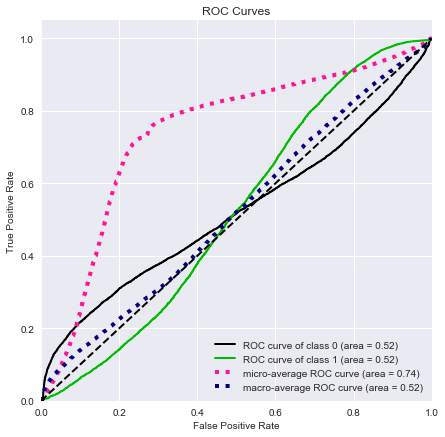

In [395]:
y_probas = lr.predict_proba(X_train)
y_true = y_train

import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc(y_true, y_probas, figsize=(7,7))
plt.show()

In [385]:
y_true.unique(), y_true.shape

(array([1, 0], dtype=uint64), (37477,))

In [391]:
np.unique(y_probas), y_probas.shape

(array([0.12454794, 0.12724985, 0.13225069, ..., 0.86774931, 0.87275015,
        0.87545206]), (37477, 2))

In [382]:
y_probas

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [398]:
from imblearn.over_sampling import RandomOverSampler

In [399]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 36544), (1, 36544)]


In [400]:
lr = LogisticRegression()
lr.fit(X_resampled, y_resampled)
lr.score(X_resampled, y_resampled)

0.5212073117338003

# Model with cvec body, cvec head, and cosine similarity

In [404]:
cvec_vector = CountVectorizer(stop_words='english')

cvec_articleBody_matrix_sparse = cvec_vector.fit_transform(df_all['articleBody'])
cvec_articleBody_matrix_sparse

<49970x22888 sparse matrix of type '<class 'numpy.int64'>'
	with 6940371 stored elements in Compressed Sparse Row format>

In [417]:
cvec_body_array = cvec_articleBody_matrix_sparse.toarray()

In [419]:
df_cvec = pd.DataFrame(cvec_body_array)

In [420]:
df_cvec.head()

,0,1,2,3,4,5,6,7,8,9,...,22878,22879,22880,22881,22882,22883,22884,22885,22886,22887
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [425]:
cvec_vector = CountVectorizer(stop_words='english')

cvec_headline_matrix_sparse = cvec_vector.fit_transform(df_all['Headline'])

cvec_headline_matrix_sparse

<49970x3164 sparse matrix of type '<class 'numpy.int64'>'
	with 403074 stored elements in Compressed Sparse Row format>

In [427]:
cvec_vector.get_feature_names

<bound method CountVectorizer.get_feature_names of CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)>

In [429]:
cvec_headline_df = pd.DataFrame(cvec_headline_matrix_sparse.todense(),
                       columns = cvec_vector.get_feature_names())


In [430]:
cvec_headline_df.shape

(49970, 3164)

In [432]:
df_fix.shape

(49970, 2)

In [434]:
df_headline_fix = pd.concat([df_fix, cvec_headline_df], axis=1)

In [444]:
df_headline_fix.fillna(value=0, inplace=True)

In [445]:
features = [col for col in df_headline_fix.columns if col != 'Unnamed 0']

In [446]:
X = df_headline_fix[features]
y = df_headline_fix['Unnamed 0']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [447]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.7314762933909656

In [448]:
lr.score(X_test, y_test)

0.7305691187064757

In [450]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.9595240001067264

In [451]:
rf.score(X_test, y_test)

0.5772032338109341